Using device: cpu


100%|██████████| 170M/170M [00:20<00:00, 8.17MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch [1/20] - Loss: 1.8058 - Train Acc: 35.32% - Val Acc: 43.84%
Epoch [2/20] - Loss: 1.6441 - Train Acc: 41.70% - Val Acc: 44.86%
Epoch [3/20] - Loss: 1.5690 - Train Acc: 44.65% - Val Acc: 48.05%
Epoch [4/20] - Loss: 1.5275 - Train Acc: 46.30% - Val Acc: 49.11%
Epoch [5/20] - Loss: 1.4910 - Train Acc: 47.60% - Val Acc: 49.75%
Epoch [6/20] - Loss: 1.4559 - Train Acc: 48.59% - Val Acc: 50.16%
Epoch [7/20] - Loss: 1.4252 - Train Acc: 49.61% - Val Acc: 51.31%
Epoch [8/20] - Loss: 1.3991 - Train Acc: 50.45% - Val Acc: 51.29%
Epoch [9/20] - Loss: 1.3770 - Train Acc: 51.45% - Val Acc: 50.52%
Epoch [10/20] - Loss: 1.3570 - Train Acc: 52.13% - Val Acc: 52.64%
Epoch [11/20] - Loss: 1.3294 - Train Acc: 53.18% - Val Acc: 52.38%
Epoch [12/20] - Loss: 1.3118 - Train Acc: 53.26% - Val Acc: 52.87%
Epoch [13/20] - Loss: 1.2936 - Train Acc: 54.50% - Val Acc: 52.93%
Epoch [14/20] - Loss: 1.2824 - Train Acc: 54.67% 

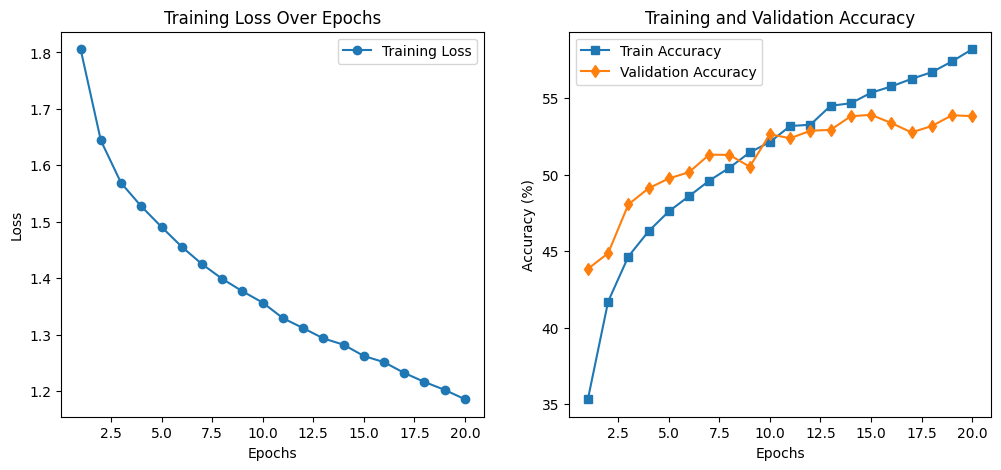


Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.61      0.62      1000
           1       0.64      0.67      0.66      1000
           2       0.45      0.33      0.38      1000
           3       0.35      0.45      0.39      1000
           4       0.39      0.54      0.45      1000
           5       0.54      0.28      0.37      1000
           6       0.54      0.66      0.59      1000
           7       0.69      0.55      0.61      1000
           8       0.63      0.72      0.67      1000
           9       0.64      0.57      0.61      1000

    accuracy                           0.54     10000
   macro avg       0.55      0.54      0.54     10000
weighted avg       0.55      0.54      0.54     10000



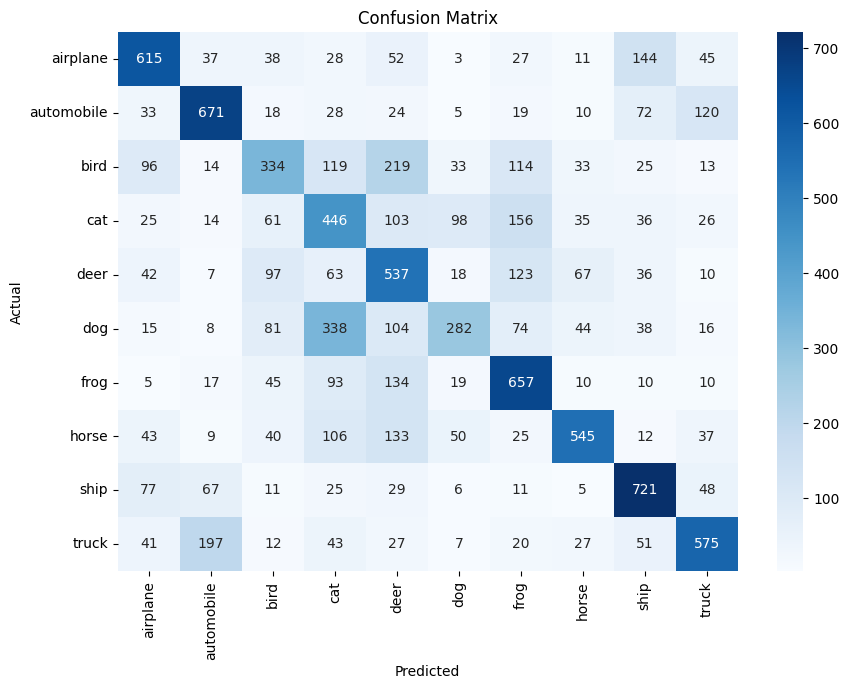


Model saved successfully as 'mlp_cifar10.pth'.


In [1]:
###Base

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

#deefine MLP
class MLP(nn.Module):
    def __init__(self, input_dim=32*32*3, hidden_dims=[512, 256, 128], output_dim=10):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.fc3 = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.fc4 = nn.Linear(hidden_dims[2], output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

          ###initialize model, loss function, and optimizer
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


epochs = 20
train_losses, train_accuracies, val_accuracies = [], [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(trainloader))
    train_accuracies.append(100 * correct / total)

          ####validation accuracy///
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    val_accuracies.append(100 * correct / total)

    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {train_losses[-1]:.4f} - Train Acc: {train_accuracies[-1]:.2f}% - Val Acc: {val_accuracies[-1]:.2f}%")

###plot training loss and accuracy//
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, marker='o', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, marker='s', label='Train Accuracy')
plt.plot(range(1, epochs+1), val_accuracies, marker='d', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()


y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())


conf_matrix = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred)

#classification
print("\nClassification Report:\n", class_report)

    #confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=trainset.classes, yticklabels=trainset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

      #save model
torch.save(model.state_dict(), "mlp_cifar10.pth")
print("\nModel saved successfully as 'mlp_cifar10.pth'.")
